# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from time import time
# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

display(feat_info)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [4]:
display(azdias.head())

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
f =  "Does" if (len(azdias.columns) == len(feat_info)) else "Doesn't"
print('There are', len(feat_info),'features in the summary, and it,',f,'match the number features in the dataset')
print('And there are',len(azdias),'rows in the dataset')

There are 85 features in the summary, and it, Does match the number features in the dataset
And there are 891221 rows in the dataset


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [854]:
##This function helps us only convert the float values
## HELPER
def toFloat(n):
    try: 
        return float(n)
    except ValueError:
        return n
    
def str_list(l):
    return list(map(toFloat, l[1:-1].split(',')))
def get_mv(attr,feat_info):
    return str_list(list(feat_info[feat_info['attribute']==attr]['missing_or_unknown'])[0])

def remove_missing(data,feat_info):
    for attr in data.columns.values:
        mv = get_mv(attr,feat_info)
        if mv:
            data[attr] = data[attr].replace(mv, np.nan) 
    return data

In [11]:
nan_ratio = {}
for attr in azdias.columns.values:
    mv = get_mv(attr,feat_info)
    if mv:
        azdias[attr] = azdias[attr].replace(mv, np.nan) 
        nan_ratio[attr] = azdias[attr].isnull().sum()/len(azdias)
nan_ratio_df = pd.DataFrame(list(zip(nan_ratio.keys(),nan_ratio.values())),columns=['attribute','nan ratio'])

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# Investigate patterns in the amount of missing data in each column.
patterns = azdias.isnull().sum().value_counts()
patterns = pd.DataFrame(patterns,columns=['Attr count'])
patterns.loc[:,'ratio'] = pd.Series(['%{:.2f}'.format(x*100/len(azdias)) for x in patterns.index], 
                                    index=patterns.index)

patterns.head(13)

,Attr count,ratio
0,24,%0.00
116515,7,%13.07
4854,6,%0.54
133324,6,%14.96
93148,4,%10.45
73499,4,%8.25
111196,3,%12.48
99352,3,%11.15
93740,3,%10.52
97375,2,%10.93


There are 6 attributes with outlier number of missing values:


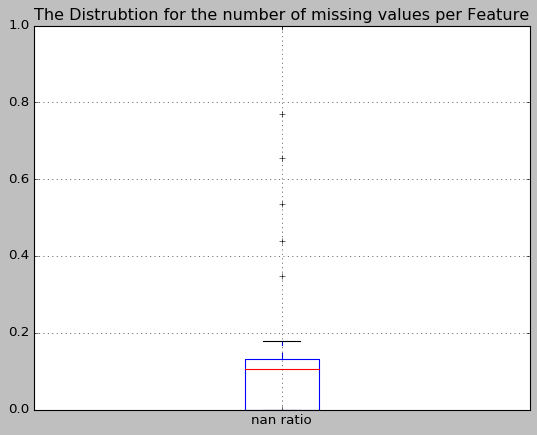

,attribute,nan ratio
0,AGER_TYP,0.770
11,GEBURTSJAHR,0.440
40,TITEL_KZ,0.998
43,ALTER_HH,0.348
47,KK_KUNDENTYP,0.656
64,KBA05_BAUMAX,0.535


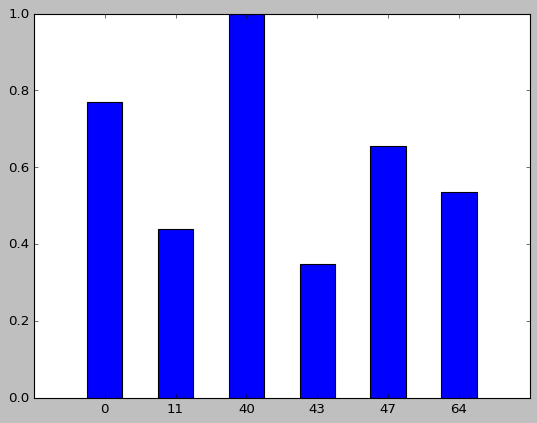

In [1180]:
S = nan_ratio_df['nan ratio']
outliers = S[~((S-S.mean()).abs() <= 1*S.std())]
bad_attr = nan_ratio_df.iloc[outliers.index]
print("There are {} attributes with outlier number of missing values:".format(len(bad_attr)))
plt.title('The Distrubtion for the number of missing values per Feature')
nan_ratio_df.boxplot(column=['nan ratio'])
plt.show()

display(bad_attr.round(3))
x = np.arange(len(bad_attr['nan ratio']))
plt.bar(x, height= bad_attr['nan ratio'],width=0.5) 
plt.xticks(x, bad_attr.index)
plt.show()


In [251]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
remove_col = list(bad_attr['attribute'])
azdias.drop(remove_col, axis=1, inplace=True, errors='ignore')
feat_info.drop(bad_attr.index, axis=0, inplace=True, errors='ignore')

print('Removed',remove_col)

Removed ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


#### Discussion 1.1.2: Assess Missing Data in Each Column
As can be seen above, there pattern between missing values through different columns is not signicant, so we ignore it. However, we have seen 6 attributes with outlier number of missing values, so we droped these attributes from the dataset. The dropped columns are the following :

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Number of missing valuse by row:


,Row count,ratio
7,783,%5.38
6,13122,%4.62
5,329,%3.85
4,698,%3.08
3,20138,%2.31
2,42394,%1.54
1,46434,%0.77
0,623211,%0.00


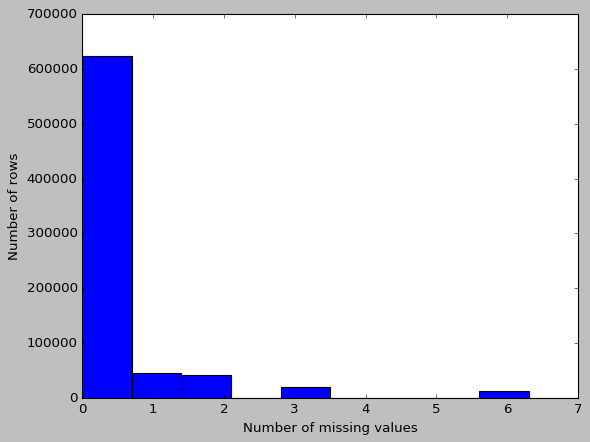

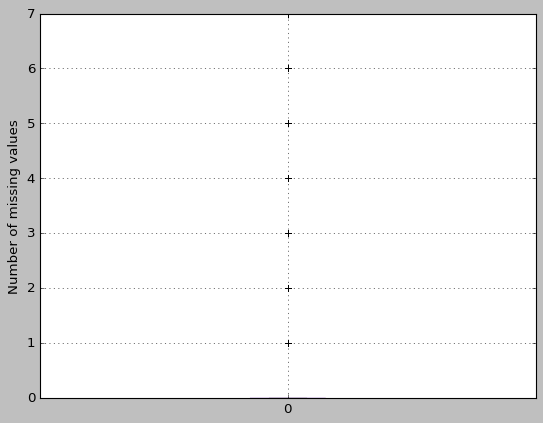

The upper bound outlier for number of missing values in this data set is 0.00
The percentage of rows that have outlier number of missing values is %16.58


In [1181]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
row_missing = azdias.isnull().sum(axis=1)
patterns_row = row_missing.value_counts()
patterns_row = pd.DataFrame(patterns_row,columns=['Row count'])
patterns_row.loc[:,'ratio'] = pd.Series(['%{:.2f}'.format(x*100/len(azdias.columns)) for x in patterns_row.index], 
                                    index=patterns_row.index)
patterns_row.sort_index(inplace=True,ascending=False)


q1, q3= np.percentile(row_missing,[25,75])
iqr = q3 - q1
min_outlier = q3 +(1.5 * iqr)
outlier_pcg = len(row_missing[row_missing>min_outlier])*100/len(row_missing)

print('Number of missing valuse by row:')
display(patterns_row.head(13))

row_missing.hist(grid=False);
plt.xlabel('Number of missing values')
plt.ylabel('Number of rows')
plt.show()

row_missing.to_frame().boxplot()
plt.ylabel('Number of missing values')
plt.show()

print("The upper bound outlier for number of missing values in this data set is {:.2f}".format(min_outlier))
print("The percentage of rows that have outlier number of missing values is %{:.2f}".format(outlier_pcg))

In [132]:
row_above_th = row_missing[row_missing>min_outlier]
row_below_th = row_missing[row_missing<=min_outlier]

In [133]:
azdias_below = azdias.iloc[row_below_th.index]
azdias_above = azdias.iloc[row_above_th.index]

In [1182]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
for df in [azdias_below,azdias_above]:
    df   = df[['ANREDE_KZ','FINANZ_HAUSBAUER','FINANZ_MINIMALIST','FINANZ_VORSORGER','FINANZTYP']].copy()
    df.columns = np.arange(1,6)
    corr = df.corr()
    corr = corr.style.background_gradient(cmap='Blues').set_properties(**{'font-size': '0pt; width: 70pt'})
    display(corr)

,1,2,3,4,5
1,1,0.228305,-0.301141,-0.0218637,-0.178019
2,0.228305,1,-0.576922,0.108167,-0.205278
3,-0.301141,-0.576922,1,0.494649,0.449105
4,-0.0218637,0.108167,0.494649,1,0.297581
5,-0.178019,-0.205278,0.449105,0.297581,1


,1,2,3,4,5
1,1,0.146599,-0.225203,-0.0440778,-0.132874
2,0.146599,1,-0.656033,-0.002198,-0.134416
3,-0.225203,-0.656033,1,0.474572,0.363629
4,-0.0440778,-0.002198,0.474572,1,0.0681178
5,-0.132874,-0.134416,0.363629,0.0681178,1


**Observation**: The two subsets both follow the same distribution

In [204]:
print(len(azdias),'-',len(row_above_th.index),'=')
azdias = azdias_below
print(len(azdias))

891221 - 144112 =
747109


#### Discussion 1.1.3: Assess Missing Data in Each Row
By applying simple statistcs we find out that the rows with more than 7 values missing are considered as outliers, thus they should be removed. When we compare the rows with many missing values to the ones with few to no missing values, we observed that they both follow the same distribution, thus deleting the rows with many missing values won't make a difference 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [255]:
# How many features are there of each data type?
feat_info.iloc[:,[0,2]].groupby('type').count()

,attribute
type,
categorical,18
mixed,6
numeric,6
ordinal,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [399]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cate_attrs = list(feat_info[feat_info['type']=='categorical']['attribute'])
azdias_cate = azdias[cate_attrs]
s1 = azdias_cate.nunique()
s2 = azdias_cate.min()
s3 = azdias_cate.max()
cate_summary = pd.concat({'Type': azdias_cate.dtypes,'#Values':s1,'Min value': s2,'Max value': s3}, 
                         axis=1, sort=False)
cate_summary

,#Values,Max value,Min value,Type
ANREDE_KZ,2,2,1,int64
CJT_GESAMTTYP,6,6,1,float64
FINANZTYP,6,6,1,int64
GFK_URLAUBERTYP,12,12,1,float64
GREEN_AVANTGARDE,2,1,0,int64
LP_FAMILIE_FEIN,11,11,1,float64
LP_FAMILIE_GROB,5,5,1,float64
LP_STATUS_FEIN,10,10,1,float64
LP_STATUS_GROB,5,5,1,float64
NATIONALITAET_KZ,3,3,1,float64


**Observation:** We can see that there are some attributes that don't produce proper values for min and max in the tables above, and the reason because taht the these features aren't numeraic. Thus they should be re-encoded

In [563]:
azdias_cate1 = azdias_cate.copy()

In [909]:
def preprocess_cate(data,feat_info):
    cate_attrs = list(feat_info[feat_info['type']=='categorical']['attribute'])
    data_cate = data[cate_attrs]

    #Re-encoding binary features to be binary
    ## 2 encoded to 1 and 1 encoded to 0
    ANREDE_KZ_rencoded = data_cate['ANREDE_KZ'].apply(lambda x: 1 if x == 2 else 0 if x == 1 else np.nan)
    VERS_TYP_rencoded = data_cate['VERS_TYP'].apply(lambda x: 1 if x == 2 else 0 if x == 1 else np.nan)
    ## 'W' encoded to 1 and 'O' encoded to '0'
    OST_WEST_KZ_rencoded = data_cate['OST_WEST_KZ'].apply(lambda x: 1 if x == 'W' else 'O' if x == 1 else np.nan)

    ##Concat
    data_cate = pd.concat([data_cate,ANREDE_KZ_rencoded,VERS_TYP_rencoded,OST_WEST_KZ_rencoded],1)
    data_cate.drop(['ANREDE_KZ','VERS_TYP','OST_WEST_KZ'],axis=1,inplace=True)

    # Re-encoded n-nary features
    ## From the Data dictionary we can determanine that the CAMEO_DEUG_2015 can be reduced into three levels
    CAMEO_DEUG_2015 = pd.to_numeric((data_cate['CAMEO_DEUG_2015']));
    Social_class = CAMEO_DEUG_2015.apply(getClass).to_frame()
    CAMEO_DEUG_2015_rencoded = pd.get_dummies(Social_class, prefix_sep='')
    ## Reduce GEBAEUDETYP to residential or not
    GEBAEUDETYP_rencoded = data_cate['GEBAEUDETYP'].apply(lambda x: 1 if x in [1,2,3] else 0)
    GEBAEUDETYP_rencoded = GEBAEUDETYP_rencoded.to_frame('Building_type')

    # Onhotencode Features
    onehotencoded_features = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP',
                              'ZABEOTYP','LP_STATUS_FEIN','LP_FAMILIE_FEIN',
                              'LP_FAMILIE_FEIN','SHOPPER_TYP','NATIONALITAET_KZ']
    onehotencoded_df = onehotencode(onehotencoded_features, data=data_cate)
    data_cate = pd.concat([data_cate,GEBAEUDETYP_rencoded,CAMEO_DEUG_2015_rencoded,onehotencoded_df],1)
    data_cate.drop(onehotencoded_features+['CAMEO_DEUG_2015','GEBAEUDETYP'],axis=1,inplace=True)
    # Droped n-nary features
    data_cate.drop(['CAMEO_DEU_2015','LP_FAMILIE_GROB','LP_STATUS_GROB'],axis=1,inplace=True)
    
    return data_cate, cate_attrs
    

In [833]:
azdias_cate, cate_attrs = preprocess_cate(azdias,feat_info)
azdias.drop(cate_attrs,axis=1,inplace=True)
azdias = pd.concat([azdias,azdias_cate],1)

In [910]:
## PREPROCESSING HELPER METHODS
## This is a helper method to group the levels in CAMEO_DEUG_2015 and labels them
def getClass(x):
    if x in [1]:
        return 'Upper_class'
    elif x in [2,3,4]: 
        return 'Upper_middle_class'
    elif x in [5,6,7]:
        return 'Lower_middle_class'
    elif x in [8,9]:
        return 'Working_class'
    else:
        return np.nan
## This function will take an attribute name or a list of attribute names
## It returns a concatated or a list of onehotencoded dataframes of the input attribute(s)
def onehotencode(features, data=azdias_cate, concat= True):
    features = [features] if type(features) == str else features
    features_rencoded = []
    for feature in features:
        feature = data[feature].astype(str).to_frame()
        feature_rencoded = pd.get_dummies(feature)
        feature_rencoded = feature_rencoded.drop(feature_rencoded.columns[-1],1)
        features_rencoded.append(feature_rencoded)
        
    if concat:
        features_rencoded = pd.concat(features_rencoded,1)  
    else:
        features_rencoded = features_rencoded[0] if len(features_rencoded) == 1 else features_rencoded
        
    return features_rencoded
##FOR 'PRAEGENDE_JUGENDJAHRE' attribute
def gen_ord(x):
    gen_value = [[1,2],[3,4],[5,6,7],[8,9],[10,11,12,13],[14,15]]
    for i,y in enumerate(gen_value):
        if x in y:
            return i
    return np.nan

#### Discussion 1.2.1: Re-Encode Categorical Features
I studied each indevisual features and made judgment weather to keep them or encode it in certain way. Some features compensated for each other so I chose to keep part of them and drop the other.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [811]:
# azdias_before_rencode2 = azdias.copy()
mix_attrs = list(feat_info[feat_info['type']=='mixed']['attribute'])
azdias_mix = azdias[mix_attrs]
s1 = azdias_mix.nunique()
s2 = azdias_mix.min()
s3 = azdias_mix.max()
mix_summary = pd.concat({'#Values':s1,'max value': s2,'Min value': s3}, axis=1,sort=True)

In [812]:
mix_summary

,#Values,Min value,max value
CAMEO_INTL_2015,21,NaN,NaN
LP_LEBENSPHASE_FEIN,40,40.0,1.0
LP_LEBENSPHASE_GROB,12,12.0,1.0
PLZ8_BAUMAX,5,5.0,1.0
PRAEGENDE_JUGENDJAHRE,15,15.0,1.0
WOHNLAGE,8,8.0,0.0


In [907]:
def preprocess_mix(data,feat_info):
    mix_attrs = list(feat_info[feat_info['type']=='mixed']['attribute'])
    data_mix = data[mix_attrs]
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    gen = data_mix['PRAEGENDE_JUGENDJAHRE'].apply(gen_ord).to_frame('Generation')
    movement = data_mix['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in [2,4,6,7,9,11,13,15] else 0).to_frame('Movement')
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    CAMEO_INTL_2015 = pd.to_numeric(data_mix['CAMEO_INTL_2015'])
    life_stage = CAMEO_INTL_2015.apply(lambda x: np.nan if np.isnan(x) else x%10).to_frame('Life_stage')
    wealth_stage = CAMEO_INTL_2015.apply(lambda x: np.nan if np.isnan(x) else int(x/10)).to_frame('Wealth_stage')
    
    data_mix = pd.concat([gen,movement,wealth_stage,life_stage],1)
    return data_mix, mix_attrs
    


In [831]:
azdias_mix, mix_attrs = preprocess_mix(azdias_before_rencode,feat_info)
azdias = pd.concat([azdias,azdias_mix],1)
azdias.drop(mix_attrs,axis=1,inplace=True, errors='ignore')

#### Discussion 1.2.2: Engineer Mixed-Type Features
I have re-encoded the features mentioned following the same suggested methods, and droped the other mixed features because they were too complex to be unmixed

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [1308]:
def clean_data(data,feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    remove_missing(data,feat_info)
    print('missing removed')
    # Remove selected columns and rows, ...
    ## Columns
    ### These are the columns that have been chosen to be dropped in the analysis
    remove_col = {0: 'AGER_TYP',11: 'GEBURTSJAHR',40: 'TITEL_KZ',43: 'ALTER_HH',47: 'KK_KUNDENTYP',64: 'KBA05_BAUMAX'}
    data.drop(list(remove_col.values()), axis=1, inplace=True, errors='ignore')
    feat_info.drop(list(remove_col.keys()), axis=0, inplace=True, errors='ignore')
    print('columns dropped')
    ## Rows
    row_missing = data.isnull().sum(axis=1)
    ### The Thresh that have been calcuated in the analysis is less than 7.5 features missing
    row_below_th = row_missing[row_missing<=7]
    data = data.iloc[row_below_th.index]
    print('rows removed')
    # Select, re-encode, and engineer column values.
    ## Mixed columns
    data_mix, mix_attrs = preprocess_mix(data,feat_info)
    data = pd.concat([data,data_mix],1)
    data.drop(mix_attrs,axis=1,inplace=True, errors='ignore')
    print('mixed encoded')
    ## Cate columns
    data_cate, cate_attrs = preprocess_cate(data,feat_info)
    data.drop(cate_attrs,axis=1,inplace=True)
    data = pd.concat([data,data_cate],1)
    print('cate encoded')
    
    # Fill the rest of the missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    data = pd.DataFrame(imputer.fit_transform(data),columns=data.columns, index= data.index)
    print('data imputed')
    # Return the cleaned dataframe.
    return data, fi
    

In [1794]:
%%time
data = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
fi = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

CPU times: user 7.05 s, sys: 2.16 s, total: 9.21 s
Wall time: 9.55 s


In [1795]:
%%time
data, fi = clean_data(data, fi)

missing removed
columns dropped
rows removed
mixed encoded
cate encoded
data imputed
CPU times: user 36.7 s, sys: 6.3 s, total: 43 s
Wall time: 44.9 s


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [1553]:
%%time
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
#From previous analysis we have seen that the percentage of missing values for each feature is not signficant
#So imputing these mising values with mode will not change the properties and the distribution of the data

# **NO LONGER NEEDED** since it was added to the clean_data function
# imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# data = pd.DataFrame(imputer.fit_transform(data),columns=data.columns, index= data.index)


CPU times: user 7.85 s, sys: 846 ms, total: 8.7 s
Wall time: 8.72 s


In [1723]:
# Apply feature scaling to the general population demographics data.
scaler = MinMaxScaler().fit(data)
data = pd.DataFrame(scaler.transform(data),columns=data.columns, index= data.index)

### Discussion 2.1: Apply Feature Scaling

From previous analysis we have seen that the percentage of missing values for each feature is not signficant, so imputing these mising values with mode will not change the properties and the distribution of the data.

For feature scalling I choose the min-max scale, because we have a lot of binary features, and I do not believe it makes sense to staderdize binary features

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [1020]:
%%time
# Apply PCA to the data.
pca = PCA(n_components=65).fit(data);


CPU times: user 1min 7s, sys: 9.26 s, total: 1min 17s
Wall time: 27.6 s


In [1188]:
%%time
data_pca = pca.transform(data)

CPU times: user 3.11 s, sys: 2.99 s, total: 6.1 s
Wall time: 5.47 s


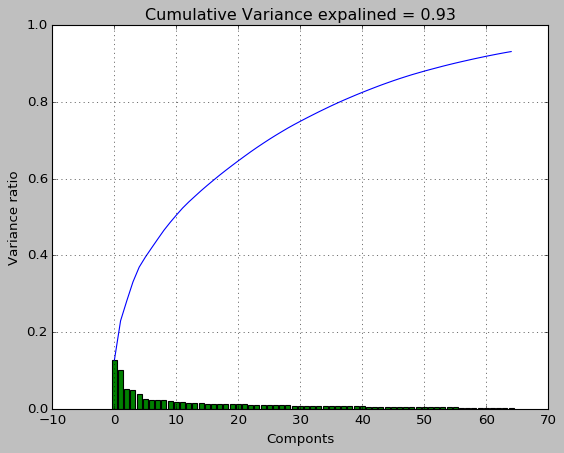

In [1183]:
# Investigate the variance accounted for by each principal component.

explained_variance_ratio = pca.explained_variance_ratio_
cummsum = np.cumsum(explained_variance_ratio)
t = np.arange(len(cummsum))

fig, ax = plt.subplots()
ax.plot(t, cummsum)
ax.set(xlabel='Componts', ylabel='Variance ratio',
       title='Cumulative Variance expalined = {:.2f}'.format(explained_variance_ratio.sum()))
ax.grid()
plt.style.use('classic')
plt.bar(t, explained_variance_ratio, align='center', alpha=1,color='g')
plt.show()

### Discussion 2.2: Perform Dimensionality Reduction
By using the PCA algorithm, we were able to reduce the number of features from 130 to 65, with cumulative variance = .93. Since calcuating the princble with minimum number of components produced good results, there is no reason to try fiting PCS with more components

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [1106]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
components = pd.DataFrame(pca.components_.T ,
                          columns = [('PCA-'+str(i+1)) for i in range(65)], index = data.columns)
c = components['PCA-1'].sort_values(ascending = False);
%%time
def p_details(i):
    pcai = 'PCA-'+str(i)
    c = components[pcai].sort_values(ascending = False) 
    print(pcai+':')
    print(pd.concat([c[c>=c[4]],c[c<=c[-5]]]).round(3))
    print('\nVariance Explained = {:.3f}'.format(pca.explained_variance_ratio_[i]))
    print('___________________________\n')

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 16 µs


In [1107]:
p_details(1)

PCA-1:
CAMEO_DEUG_2015Upper_middle_class    0.217
FINANZ_MINIMALIST                    0.216
KBA05_ANTG1                          0.194
KBA05_GBZ                            0.171
MOBI_REGIO                           0.165
FINANZ_SPARER                       -0.176
PLZ8_ANTG4                          -0.178
FINANZTYP_1                         -0.179
Wealth_stage                        -0.204
CAMEO_DEUG_2015Working_class        -0.223
Name: PCA-1, dtype: float64

Variance Explained = 0.103
___________________________



In [1109]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

p_details(2)

PCA-2:
ZABEOTYP_3               0.294
ALTERSKATEGORIE_GROB     0.210
FINANZ_VORSORGER         0.202
LP_STATUS_FEIN_1.0       0.173
RETOURTYP_BK_S           0.170
SEMIO_REL               -0.178
Generation              -0.183
FINANZ_UNAUFFAELLIGER   -0.203
FINANZ_ANLEGER          -0.209
FINANZ_SPARER           -0.220
Name: PCA-2, dtype: float64

Variance Explained = 0.052
___________________________



In [1108]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

p_details(3)

PCA-3:
SEMIO_VERT        0.308
SEMIO_SOZ         0.265
SEMIO_FAM         0.260
SEMIO_KULT        0.253
FINANZTYP_5       0.166
FINANZ_ANLEGER   -0.187
SEMIO_ERL        -0.203
SEMIO_KRIT       -0.232
SEMIO_DOM        -0.248
SEMIO_KAEM       -0.286
Name: PCA-3, dtype: float64

Variance Explained = 0.049
___________________________



### Discussion 2.3: Interpret Principal Components
When we look at the features that high weights in the second and the third component, we can see the that these featues belong to the same category in the data dictionary. We can also see that the first component mainly focus on financial information.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [1260]:
kmeans_list = []
inertia_list = []
fitting_time = []
n_clusters= 0
max_clusters = 10
while True:
    n_clusters += 1
    print('\tFitting with',n_clusters,'clusters')
    start = time()
    model = KMeans(n_clusters=n_clusters, n_jobs=-1).fit(data_pca)
    fitting_time.append(time()-start)
    kmeans_list.append(model)
    inertia_list.append(model.inertia_)
    print('\tInertia for the {} clusters = {:.2f}, Fitting time {:.2f}s'.format(n_clusters,
                                                                              model.inertia_,
                                                                              fitting_time[-1]))

    if n_clusters > 1:
        inertia_diff = np.abs((inertia_list[-1]-inertia_list[-2])/inertia_list[-2])
        if inertia_diff < 1e-3 or n_clusters >= 10:
            break


	Fitting with 1 clusters
	Inertia for the 1 clusters = 8515669.48, Fitting time5.00
	Fitting with 2 clusters
	Inertia for the 2 clusters = 7649107.54, Fitting time23.24
	Fitting with 3 clusters
	Inertia for the 3 clusters = 7128416.52, Fitting time41.57
	Fitting with 4 clusters
	Inertia for the 4 clusters = 6862159.19, Fitting time46.65
	Fitting with 5 clusters
	Inertia for the 5 clusters = 6662180.00, Fitting time63.13
	Fitting with 6 clusters
	Inertia for the 6 clusters = 6530289.39, Fitting time66.50
	Fitting with 7 clusters
	Inertia for the 7 clusters = 6413736.55, Fitting time88.45
	Fitting with 8 clusters
	Inertia for the 8 clusters = 6308245.10, Fitting time96.74
	Fitting with 9 clusters
	Inertia for the 9 clusters = 6231737.81, Fitting time95.60
	Fitting with 10 clusters
	Inertia for the 10 clusters = 6151975.61, Fitting time121.29


In [1801]:
ax.plot?

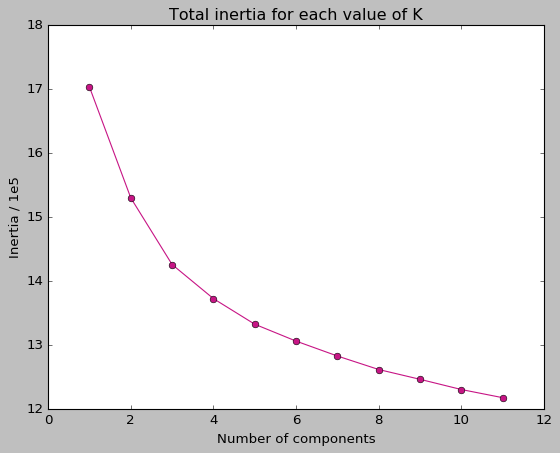

In [1805]:
df=pd.DataFrame({'x': range(1,1+len(inertia_list)), 'y': np.array(inertia_list)/1e6,
                 'z': np.array(inertia_list)*2/1e6 })
# plot with matplotlib
plt.style.use('classic')
fig, ax = plt.subplots()
ax.set(ylabel='Inertia / 1e5',xlabel='Number of components',
       title='Total inertia for each value of K')
ax.plot( 'x', 'z', data=df, marker='o', color='mediumvioletred');
plt.show()
 


**Observation** The elbow is at n_componets = 6

In [1752]:
kmeans = kmeans_list[5]
data_clustered = kmeans.predict(data_pca)

### Discussion 3.1: Apply Clustering to General Population
After appling the kmeans algorithm to many values of k, we figured out that, according to the figure above, that the best fit for the general data is to group them into 6 clusters

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [1595]:
%%time
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
fi = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

CPU times: user 1.61 s, sys: 299 ms, total: 1.91 s
Wall time: 1.92 s


In [1596]:
%%time
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers, fi = clean_data(customers, fi)
customers = pd.DataFrame(scaler.transform(customers),
                         columns=customers.columns, index= customers.index)
customers_pca = pca.transform(customers)
customers_clustered = kmeans.predict(customers_pca)

missing removed
columns dropped
rows removed
mixed encoded
cate encoded
data imputed
CPU times: user 7.71 s, sys: 1.33 s, total: 9.04 s
Wall time: 8.75 s


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [1599]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
general_prop = pd.Series(data_clustered)
general_prop = (general_prop.groupby(general_prop).count()*100/general_prop.shape[0])
general_prop = list(general_prop.round(2))

customers_prop = pd.Series(customers_clustered)
customers_prop = (customers_prop.groupby(customers_prop).count()*100/customers_prop.shape[0])

l = np.zeros(len(general_prop))
for i in customers_prop.index:
    l[i] = customers_prop[i].round(2)
customers_prop = l

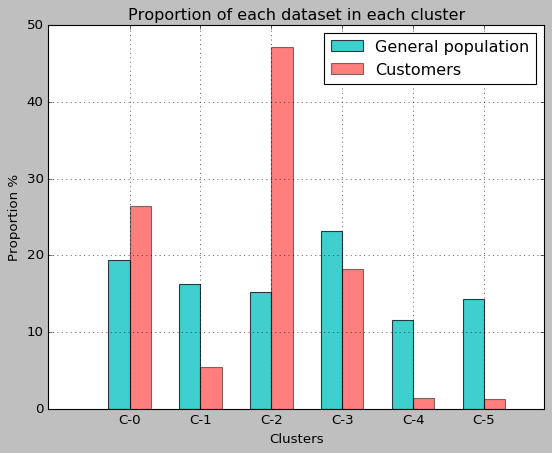

In [1600]:
barWidth = .3
r1 = np.arange(len(general_prop))
r2 = [x + barWidth for x in r1]


fig, ax = plt.subplots()
ax.bar(r1, general_prop, width = barWidth, color = 'c',alpha=.75,
       edgecolor = 'black', capsize=7, label='General population')

ax.bar(r2, customers_prop, width = barWidth, color = 'red',alpha=.5,
       edgecolor = 'black', capsize=7, label='Customers')

ax.set(ylabel='Proportion %',xlabel='Clusters',
       title='Proportion of each dataset in each cluster')
ax.grid()
plt.xticks([r+barWidth/2  for r in range(len(general_prop))],
           ['C-'+str(i) for i in range(len(general_prop))])
plt.style.use('classic')
plt.legend()
plt.show()

**Observation** from the bar plot above we can observe that the overrepresented cluster in the customer dataset is cluster number 2, and the overrepresented cluster is cluster number 5

In [1756]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#Label the rows with the assigned cluster
customers_labels = pd.DataFrame(customers_clustered,columns=['Cluster'],index=customers.index)
customers_labels = pd.concat([customers_labels, customers],1)
data_labels = pd.DataFrame(data_clustered,columns=['Cluster'],index=data.index)
data_labels = pd.concat([data_labels, data],1)
display(data_labels.head())
display(customers_labels.head())


,Cluster,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0
1,3,0.000000,0.00,1.00,0.25,1.00,0.75,1.00,1.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,3,0.666667,0.00,0.75,0.00,0.25,0.50,1.00,1.0,0.50,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,2,1.000000,0.75,0.25,1.00,0.25,0.00,0.25,0.5,0.25,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0,0.666667,0.75,0.50,0.75,0.00,0.50,0.25,1.0,1.00,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5,2,0.000000,0.50,0.00,1.00,0.25,0.25,1.00,1.0,0.50,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


,Cluster,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0
0,2,1.000000,1.0,0.0,1.00,0.00,0.25,0.25,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,2,1.000000,1.0,0.0,1.00,0.00,0.75,0.75,0.5,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0,1.000000,1.0,0.0,1.00,0.25,0.00,0.25,0.5,0.5,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,0.666667,0.5,0.0,0.75,0.75,1.00,0.25,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5,2,0.666667,1.0,0.0,1.00,0.00,0.25,0.50,1.0,0.5,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [1639]:
largest_cluster = customers_labels[customers_labels['Cluster']==2]

In [1687]:
# From we can see that %99.3 of the customers are/were part of the AVANTGARDE movments
# We can also seen that the more majority of the customers took residence in their current
largest_cluster.mean().round(3).sort_values(ascending=False)[1:3]

GREEN_AVANTGARDE    0.993
Movement            0.993
dtype: float64

In [1684]:
# Household for more than 10 years.
largest_cluster.groupby('WOHNDAUER_2008').count()[['Cluster']]*100/len(largest_cluster)

,Cluster
WOHNDAUER_2008,
0.000,0.041373
0.125,0.022278
0.250,0.582404
0.375,0.687427
0.500,0.531483
0.625,0.792451
0.750,0.615820
0.875,2.587400
1.000,94.139363


In [1685]:
# We can see that the majority of the customers in this cluster hold Germen sounding names
largest_cluster[['NATIONALITAET_KZ_1.0','NATIONALITAET_KZ_2.0','NATIONALITAET_KZ_3.0']].mean()

NATIONALITAET_KZ_1.0    0.974715
NATIONALITAET_KZ_2.0    0.011441
NATIONALITAET_KZ_3.0    0.006795
dtype: float64

In [1718]:
# The cluster is largerly(%63) of people who are estimated to be older than 60 years
age_group = largest_cluster.groupby(['ALTERSKATEGORIE_GROB']).count()['Cluster']
age_group = (age_group*100/len(largest_cluster)).round(2)
age_group.index = age_group.index*3 + 1
age_group

ALTERSKATEGORIE_GROB
1.0     1.68
2.0     1.98
3.0    33.41
4.0    62.93
Name: Cluster, dtype: float64

In [1665]:
# Below are the mean value of each feature in the overrepresented cluster
largest_cluster.mean().round(3).sort_values(ascending=False)

Cluster                 2.000
GREEN_AVANTGARDE        0.993
Movement                0.993
WOHNDAUER_2008          0.980
NATIONALITAET_KZ_1.0    0.975
FINANZ_MINIMALIST       0.941
FINANZ_VORSORGER        0.923
Building_type           0.876
ALTERSKATEGORIE_GROB    0.859
SEMIO_LUST              0.797
LP_STATUS_FEIN_10.0     0.775
KBA05_GBZ               0.758
SEMIO_VERT              0.756
GEBAEUDETYP_RASTER      0.746
RETOURTYP_BK_S          0.742
KBA05_ANTG1             0.703
PLZ8_GBZ                0.703
PLZ8_ANTG1              0.685
Life_stage              0.673
PLZ8_HHZ                0.671
PLZ8_ANTG2              0.669
ONLINE_AFFINITAET       0.645
W_KEIT_KIND_HH          0.640
MOBI_REGIO              0.630
EWDICHTE                0.622
SEMIO_ERL               0.607
SEMIO_SOZ               0.588
ORTSGR_KLS9             0.555
ZABEOTYP_1              0.544
INNENSTADT              0.522
                        ...  
FINANZTYP_3             0.023
GFK_URLAUBERTYP_2.0     0.019
GFK_URLAUB

In [1757]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#Cluster number 5 is the most underrepresented cluster in the customer dataset
smallest_cluster = customers_labels[customers_labels['Cluster']==5]

In [1769]:
# The %52 of the popluation in the underrepresented cluster were politcly active in
# the 90s, so they're approxmitly on there 40s
gen_clust = smallest_cluster.groupby('Generation').count()[['Cluster']]
gen_clust = gen_clust*100/len(smallest_cluster)
gen_clust.index = gen_clust.index*5+1
gen_clust.round(2)

,Cluster
Generation,
1.0,0.11
2.0,7.55
3.0,0.61
4.0,11.24
5.0,28.23
6.0,52.26


In [1792]:
# About %80 of the popluation in the underrepresented cluster 
# have low to very low income score. and more than %90 are from the lower middle class
#or from the working class
income_clust = smallest_cluster.groupby('HH_EINKOMMEN_SCORE').count()[['Cluster']]
income_clust = income_clust*100/len(smallest_cluster)
income_clust.index = income_clust.index*5+1
smallest_cluster.filter(regex='CAMEO_DEUG_2015').mean()*100


CAMEO_DEUG_2015Lower_middle_class    42.537731
CAMEO_DEUG_2015Upper_class            1.621017
CAMEO_DEUG_2015Upper_middle_class     7.546115
CAMEO_DEUG_2015Working_class         48.015651
dtype: float64

In [1791]:
income_clust.round(2)

,Cluster
HH_EINKOMMEN_SCORE,
1.0,0.34
2.0,0.56
3.0,3.24
4.0,15.99
5.0,38.68
6.0,41.20


In [1788]:
# We can observe that %50 of the customers in this cluster are price driven
z_clust = smallest_cluster.filter(regex='ZABEOTYP_').mean()*100
z_clust

ZABEOTYP_1     1.844606
ZABEOTYP_2     1.341532
ZABEOTYP_3     7.657909
ZABEOTYP_4    50.698714
ZABEOTYP_5    21.967580
dtype: float64

In [1758]:
# Below are the mean value of each feature in the underrepresented cluster
smallest_cluster.mean().round(3).sort_values(ascending=False)

Cluster                       5.000
SEMIO_DOM                     0.883
SEMIO_KAEM                    0.880
Generation                    0.833
HH_EINKOMMEN_SCORE            0.831
PLZ8_ANTG2                    0.831
EWDICHTE                      0.823
WOHNDAUER_2008                0.805
NATIONALITAET_KZ_1.0          0.783
PLZ8_ANTG3                    0.777
Wealth_stage                  0.764
SEMIO_KRIT                    0.756
Building_type                 0.738
ONLINE_AFFINITAET             0.728
ORTSGR_KLS9                   0.726
SEMIO_RAT                     0.725
FINANZ_HAUSBAUER              0.721
FINANZTYP_1                   0.714
FINANZ_SPARER                 0.708
PLZ8_HHZ                      0.701
FINANZ_ANLEGER                0.692
SEMIO_PFLICHT                 0.684
SEMIO_ERL                     0.677
RELAT_AB                      0.658
REGIOTYP                      0.634
FINANZ_UNAUFFAELLIGER         0.625
HEALTH_TYP                    0.613
PLZ8_ANTG4                  

### Discussion 3.3: Compare Customer Data to Demographics Data
From the analysis above, we can clearly figure out that the target customers for the mail delivery service are wealthy, upper class elderly, and the segement of the customers who are less intrested about this service are middle aged lower middle class people

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.